# Mean and Covariance functions.

In this tutorial, we will explore the mean and covariance functions present in `pm.gp` module and study their properties. This will help choose appropriate kernel and mean function to model your data properly. We will also see the sementics of additive and multiplicative kernels.

In [1]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap

import tensorflow as tf

import pymc4 as pm
from pymc4.gp.cov import *
from pymc4.gp.util import stabilize

## Basic API Walkthrough

### Constant Kernel 

Constant kernel just evaluates to a constant value in each entry of the covariance matrix irrespective of the input. It is very useful as a lightweight kernel when speed and performance is a primary goal. It doesn’t evaluate a complex function and so its gradients are faster and easier to compute. This kernel is most appropriate for modelling large data withut any prior information.

The mathematical formula of the constant kernel is pretty straight forward:

$$k(x, x') = c$$

The signature of the constant kernel implemented in `pymc4` is:

```python
K = Constant(coef, feature_ndims=1, active_dims=None, scale_diag=None)
```

First argument `coef` to the constructor is the constant value `c` which represents the covariance between any two points. Thus, the covariance matrix just evaluates to this constant value.

The argument `feature_ndims` is the number of feature dimensions of the input between which you want to evaluate the covariance. We will see the effect of this agument later.

Third argument `active_dims` is the feature or the number of features of each of the `feature_ndims` number of feature dimensions that will be considered during the computation. We will explore this in detail later.

The last argument `scale_diag` is used to perform **A**utomatic **R**elevance **D**etermination (ARD) and is a scaling factor of the ``length_scale`` parameter of stationary covariance kernels.

One important boolean keyword argument is `ARD` that tells ``pymc4`` weather or not to perform ARD which doing GP Modelling. Its defualt value is `True`. A little overhead is incurred when ``ARD`` is enabled.

These four arguments `feature_ndims`, `active_dims`, `scale_diag`, and `ARD` are common in all the kernels implemented in ``pymc4`` and optional.

In [2]:
coef = 1.

k = Constant(coef=coef)

We can call the object `k` to evaluate the covariance matrix between two arrays or tensors of points. It outputs a covariance matrix which is a `tf.Tensor` object.

For inputs with shape `(b_10, b_11, ..., m, k_10, k_11, ...)` and `(b_20, b_21, ..., n, k_20, k_21, ...)` where ``(b_10, b_11, ...)`` is the batch shape of first tensor and `(b_20, b_21, ...)` is the batch shape of the second tensor. Batch shapes must be equal or broadcastable. `(k_10, k_11, ...)` and `(k_20, k_21, ...)` are the feature dimensions and their length is equal to `feature_ndims`. The feature dimensions don't need to be broadcastable.

When the kernel object `k` is called on such inputs, it outputs a tensor of shape `(b_0, b_1, ..., m, n)` where `(b_0, b_1, ...)` is the broadcasted batch shape.

Let's take some examples

#### Example 1 : Only one batch and one feature dimension.

In [3]:
# Example 1 : Only one batch and one feature dimension.

x1 = np.array([[1., 2.], [3., 4.]])
x2 = np.array([[5., 6.], [7., 8.]])

k(x1, x2)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

#### Example 2 : Multiple batch dimensions and one feature dimension

Let's batch two tensors of shape `(2, 2)` and call the kernel with that 

In [4]:
# Example 2 : Multiple batch dimensions and one feature dimension

batched_x1 = np.array([[[1., 2.], [3., 4.]], [[5., 6.], [7., 8.]]])
batched_x2 = np.array([[[9., 10.], [11., 12.]], [[13., 14.], [15., 16.]]])

print(batched_x1.shape)
print(batched_x2.shape)
print(k(batched_x1, batched_x2))

(2, 2, 2)
(2, 2, 2)
tf.Tensor(
[[[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]], shape=(2, 2, 2), dtype=float32)


#### Example 3 : Multiple batches and feature dimension

The below example has 2 batch dimensions and 2 feature dimensions. So the output will have shape with first two dimensions being the batch dimensions and other two dimensions being the number of examples in each tensor. The `feature_ndims` are absorbed during the computation.

In [5]:
# Notice that the batch shape is broadcatable but the
# feature dimensions need not be broadcastable.
batched_x1 = np.random.randn(2, 2, 5, 3, 3)
batched_x2 = np.random.randn(2, 2, 3, 2, 2)

k = Constant(coef=coef, feature_ndims=2)

print(batched_x1.shape)
print(batched_x2.shape)
print(k(batched_x1, batched_x2).shape)

(2, 2, 5, 3, 3)
(2, 2, 3, 2, 2)
(2, 2, 5, 3)


**Note**: It is not recommended to work with multiple feature dimensions as it incurs a substantial overhead.

In [6]:
%timeit k(batched_x1, batched_x2)

3.85 ms ± 708 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# Let's see how it performs with single feature dimension.

batched_x1 = batched_x1.reshape(2, 2, 5, 9)
batched_x2 = batched_x2.reshape(2, 2, 3, 4)

k = Constant(coef=coef, feature_ndims=1)

%timeit k(batched_x1, batched_x2)

3 ms ± 52 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Example 4: Active Dimensions

Active dimensions are (as the name suggests) active dimensions of each feature dimension which will be used during the computation of the covariance matrix. This sounds too complicated but easy to understand with an example. Let's say we have two feature dimensions of size `(10, )` and `(20, )`. This means that our input is going to be of shape `(..., m, 10, 20)` and `(..., n, 10, 20)`.

Active dimensions allows you to choose only those dimensions that you want the kernel to use to calculate the covariance matrix. For example, `active_dims=[5, 10]` means first 5 entries of the first feature dimension and first 10 entries of the second feature dimension will be used during the computation.

In [8]:
active_dims = [5, 10]

x1 = tf.random.normal((4, 10, 20))
x2 = tf.random.normal((5, 10, 20))

k = ExpQuad(length_scale=10., feature_ndims=2, active_dims=active_dims)

k(x1, x2)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[0.603071  , 0.57316715, 0.7394979 , 0.68407756, 0.6490645 ],
       [0.54758406, 0.599065  , 0.5555484 , 0.7091268 , 0.56394607],
       [0.6105528 , 0.5851189 , 0.6420666 , 0.7202355 , 0.6752333 ],
       [0.5454617 , 0.64811707, 0.61620027, 0.6802274 , 0.7589089 ]],
      dtype=float32)>

You can also pick the entries you want to be active for each feature dimension.

For example, `active_dims=[[1, 4, 5], 10]` means 2'ndm 4'th and 5'th entries are active in the first feature dimension and first 10 entries are active in the second feature dimension.

In [9]:
active_dims = [[1,4,5], 10]

x1 = tf.random.normal((4, 10, 20))
x2 = tf.random.normal((5, 10, 20))

k = ExpQuad(length_scale=10., feature_ndims=2, active_dims=active_dims)

k(x1, x2)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[0.7193141 , 0.6516644 , 0.7098501 , 0.6344253 , 0.81998605],
       [0.65586287, 0.7214003 , 0.80471194, 0.6570246 , 0.7246012 ],
       [0.69757175, 0.7498982 , 0.7356343 , 0.6905659 , 0.68673885],
       [0.65417284, 0.71304995, 0.77575403, 0.771676  , 0.7381051 ]],
      dtype=float32)>

### Scale Diag

This parameter is the scaling facotr for the `length_scale` parameter of stationary kernels from `SE`, `RQ`, `Matern`, and `Periodic` family. It is ignored if `ARD=False`. It is used to perform Automatic Relevance Determination (ARD) on stationary kernels. Let's see one example.

In [10]:
x1 = tf.constant([[1., 2.], [3., 4.]])
x2 = tf.constant([[1., 2.], [3., 4.]])

k = ExpQuad(length_scale=1., feature_ndims=1, ARD=False)

print(k(x1, x2))

k = ExpQuad(length_scale=1., feature_ndims=1, scale_diag=2.)

print(k(x1, x2))

tf.Tensor(
[[1.         0.01831564]
 [0.01831564 1.        ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.         0.36787945]
 [0.36787945 1.        ]], shape=(2, 2), dtype=float32)


As you can see, the off diagonal entries got scaled by `2` because `scale_diag` was `2`.

## Kernels Walkthrough

### Constant Kernel

As we have seen above, the constant kernel is a lightweight constant function and gradients are easy to calculate. Now, let's look at the function space and the covariance matrix.

In [11]:
# This is a batch of coefficients. You can batch several
# constant kernels together for fast vectorized computations.
coefs = [1., 2., 5.]

k = Constant(coef=coefs, ARD=False)

In [12]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-6)
dists = pm.MvNormal("constant_dist", loc=0., covariance_matrix=covs)
samples = dists.sample(1)

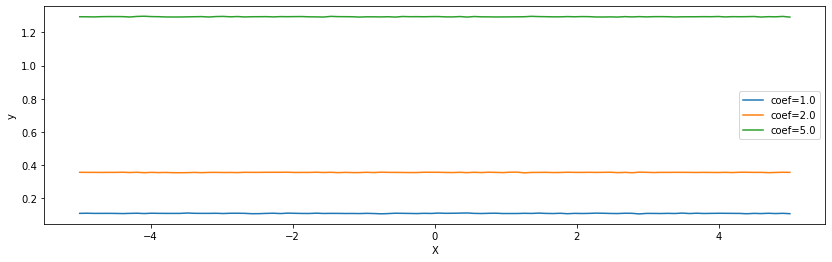

In [13]:
plt.figure(figsize=(14,4))
[plt.plot(x, samples[0, i, :], label=f"coef={coefs[i]}") for i in range(3)];
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

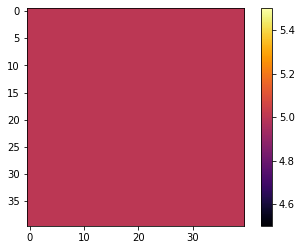

In [14]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

coef = 5.
k = Constant(coef=coef)

cov = k(X2, X2)
m = plt.imshow(cov, cmap='inferno', interpolation='none'); plt.colorbar(m);

### White Noise Kernel

This kernel adds some noise to the covariance functions and is mostly
used to stabilize other PSD kernels. This helps them become non-singular
and makes cholesky decomposition possible for sampling from the
``MvNormalCholesky`` distribution. It is recommended to use this kernel in
combination with other covariance/kernel function when working with GP on
large data.


$$
X(x_i, x_j) =
\begin{cases}
  \eta,    &   i = j \\
  0,       &   \text{otherwise}
\end{cases}
$$

where $\eta$ is 'noise level' or simply noise.

The signature of `WhiteNoise` kernel implemented in `pymc4` is:

```python
k = WhiteNoise(noise, feature_ndims=1., active_dims=None, scale_diag=None)
```

In [15]:
noises = [0.1, 0.9, 2.1]

k = WhiteNoise(noise=noises, ARD=False)

In [16]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-6)
dists = pm.MvNormal("white_noise_dist", loc=0., covariance_matrix=covs)
samples = dists.sample(1)

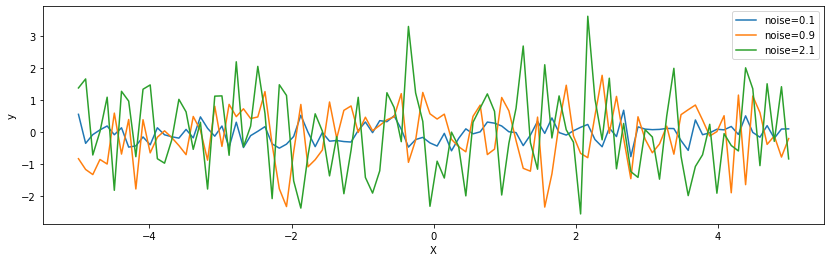

In [17]:
plt.figure(figsize=(14,4))
[plt.plot(x, samples[0, i, :], label=f"noise={noises[i]}") for i in range(3)];
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

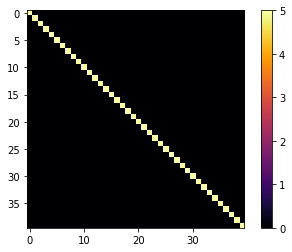

In [18]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

noise = 5.
k = WhiteNoise(noise=noise, ARD=False)

cov = k(X2, X2)
m = plt.imshow(cov, cmap='inferno', interpolation='none'); plt.colorbar(m);

### Exponentail Quadratic Kernel

This is the most used kernel in GP Modelling because of its nice properties. It is numerically very stable and infinitely differentiable. It comes from Squared Exponential (SE) family of kernels which is also commonly called as the Radial Basis Kernel Family.

It's mathematical expression is:

$$k(x, x') = \sigma^2 \exp\left( \frac{\|x-x'\|^2}{2\ell^2} \right)$$

where $\sigma$ is called "amplitude" and $\ell$ is called "length scale" of the kernel.

Amplitude controls how many units away the covariance is from the mean and length scale controls the 'wiggles' in the covariance matrix. In general, you won't be able to extrapolate more than ℓ units away from your data. If a float, an isotropic kernel is used. If an array and ``ARD=True``, an anisotropic kernel is used where each dimension defines the length-scale of the respective feature dimension.

The signature of Exponential Quadratic kernel implemented in `pymc4` is:

```python
k = ExpQuad(length_scale=1., amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [19]:
# We are using tf.float64 for better numerical accuracy.
lss  = tf.Variable([0.5, 0.8, 1.2], dtype=tf.float64)
amps = tf.Variable([1., 2., 5.], dtype=tf.float64)

k = ExpQuad(length_scale=lss, amplitude=amps, ARD=False)

In [20]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("exp_quad_dist", loc=0., covariance_matrix=covs)
samples = dists.sample(1)

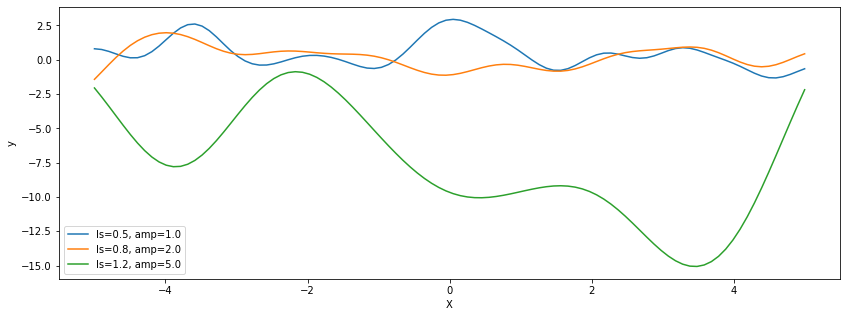

In [21]:
plt.figure(figsize=(14,5))
[plt.plot(x, samples[0, i, :], label=f"ls={lss[i]}, amp={amps[i]}") for i in range(3)];
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

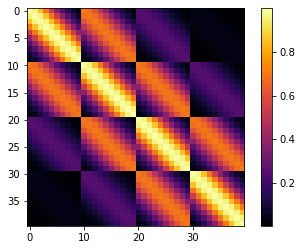

In [22]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = .8, 1.
k = ExpQuad(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
m = plt.imshow(cov, cmap='inferno', interpolation='none'); plt.colorbar(m);